# 03 Train Transformer Model
#
# Funktion:
# Dieses Notebook trainiert das TimeSeriesTransformer-Modell.
# Es verwendet die gleichen vorverarbeiteten Daten wie das LSTM-Modell, um eine faire Vergleichbarkeit zu gewährleisten.
#
# Schritte:
# 1. Konfiguration und Seeds setzen.
# 2. Daten laden (aus dem LSTM-Datenverzeichnis).
# 3. Train/Validation/Test Splits erstellen.
# 4. Daten skalieren (StandardScaler).
# 5. Dataset und DataLoader erstellen (Windowing).
# 6. Modell initialisieren.
# 7. Training mit Early Stopping durchführen.
# 8. Metriken und Loss plotten und Artefakte speichern.

In [1]:
# === IMPORTS ===
import os, sys, json, pickle, random, shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Projekt-Root zum Pfad hinzufügen, damit wir Module aus übergeordneten Ordnern laden können
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Lokale Module importieren
# WindowDataset: Erstellt Sliding Windows für Zeitreihen
# TimeSeriesTransformer: Unsere Transformer-Modell-Klasse
# directional_accuracy: Metrik zur Bewertung der Richtungsvorhersage
from finance_transformer.dataset import WindowDataset
from finance_transformer.model import TimeSeriesTransformer
from finance_transformer.metrics import directional_accuracy

# Matplotlib inline Modus aktivieren (für Plots im Notebook)
%matplotlib inline

In [2]:
# === KONFIGURATION ===
# Hyperparameter und Einstellungen für das Training.
# Diese Werte sind entscheidend für die Leistungsfähigkeit des Modells.
CFG = dict(
    ticker="AAPL",       # Aktie, auf der wir trainieren
    start="2010-01-01",  # Startdatum für die Daten
    end="2025-01-01",    # Enddatum (wird ggf. durch train_end/valid_end eingeschränkt)
    seq_len=40,          # Länge des Zeitfensters (Lookback) in Tagen
    d_model=64,          # Dimension der Embeddings/Feature-Dimension im Transformer
    nhead=4,             # Anzahl der Attention Heads (Parallelverarbeitung von Informationen)
    num_layers=2,        # Anzahl der Encoder-Layer im Transformer
    dim_ff=128,          # Dimension des Feed-Forward Networks im Transformer
    dropout=0.3,         # Dropout-Rate zur Regularisierung (Vermeidung von Overfitting)
    lr=1e-4,             # Lernrate für den Optimizer (Schrittweite beim Gradient Descent)
    weight_decay=0.05,   # L2-Regularisierung (bestraft große Gewichte)
    batch_size=64,       # Anzahl der Samples pro Gradienten-Update
    epochs=100,          # Maximale Anzahl der Trainings-Epochen
    patience=15,         # Early Stopping: Training stoppen, wenn Val Loss sich 15 Epochen nicht verbessert
    train_end="2023-12-31", # Ende des Trainingszeitraums
    valid_end="2024-12-31", # Ende des Validierungszeitraums
    seed=42,             # Zufalls-Seed für Reproduzierbarkeit
    results_dir="../results" # Ausgabeverzeichnis für Artefakte
)

# Ergebnis-Verzeichnis erstellen, falls es nicht existiert
RESULTS_DIR = ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Seeds setzen für deterministisches Verhalten (gleiche Ergebnisse bei jedem Lauf)
random.seed(CFG["seed"])
np.random.seed(CFG["seed"])
torch.manual_seed(CFG["seed"])

# Gerät auswählen (Nutze GPU falls verfügbar, sonst CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# === DATEN LADEN ===
# Wir laden den Datensatz, der bereits für das LSTM-Modell erstellt wurde.
# Dies stellt sicher, dass beide Modelle auf exakt denselben Daten trainiert und evaluiert werden.
# Der Pfad verweist auf das 'LSTM/data' Verzeichnis.
DATA_PATH = Path(r"../../LSTM/data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv").resolve()

if not DATA_PATH.exists():
    print(f"Resolving path: {DATA_PATH}")
    raise FileNotFoundError(f"{DATA_PATH} not found. Please ensure LSTM data is generated.")

# CSV einlesen, Datum als Index setzen
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
print(f"Loaded {len(df)} rows.")

# Filtern nach Startdatum aus der Config, um irrelevante historische Daten wegzulassen
df = df.loc[CFG["start"]:]
print(f"Filtered data start: {df.index[0]}")

# Feature-Spalten definieren (die gleichen 11 Features wie beim LSTM)
# Diese Features repräsentieren Renditen, Volatilität und technische Indikatoren.
feat_cols = ['logret_1d', 'logret_3d', 'logret_5d', 'realized_vol_10', 'bb_pos', 'rsi_14', 'macd', 'macd_sig', 'macd_diff', 'vol_z_20', 'sma_diff']

# Target-Spalte: Wir nutzen die "target" Spalte für binäre Klassifikation (0/1).
# 1 = Kurs steigt, 0 = Kurs fällt/bleibt gleich.
if "target" not in df.columns:
    raise ValueError("Target column not found in dataset!")
df["y"] = df["target"]
print(f"Features used: {len(feat_cols)}")

Loaded 3991 rows.
Filtered data start: 2010-02-22 00:00:00
Features used: 11


In [4]:
# === SPLIT & SCALING ===
# Zeitlicher Split der Daten in Train, Validation und Test Sets.
# Wichtig: Keine zufällige Durchmischung (Shuffle) vor dem Split, da Zeitreihendaten!

# Training: Bis Ende 2023 (Lernen der Muster)
tr_df = df.loc[:CFG["train_end"]]
# Validation: 2024 (Hyperparameter-Tuning und Early Stopping)
va_df = df.loc[pd.Timestamp(CFG["train_end"]) + pd.Timedelta(days=1):CFG["valid_end"]]
# Test: Ab 2025 (Finale Evaluation, ungesehene Daten)
te_df = df.loc[pd.Timestamp(CFG["valid_end"]) + pd.Timedelta(days=1):]

print(f"Train: {len(tr_df)}, Val: {len(va_df)}, Test: {len(te_df)}")

# Scaling: StandardScaler auf Trainingsdaten fitten.
# Wir skalieren die Features, damit sie Mittelwert 0 und Varianz 1 haben.
# Das hilft dem Neural Network, schneller und stabiler zu konvergieren.
# WICHTIG: Den Scaler nur auf Train-Daten fitten, um Data Leakage zu vermeiden!
scaler = StandardScaler().fit(tr_df[feat_cols])

# Transformation der Daten (Anwenden des gefitteten Scalers)
X_tr = scaler.transform(tr_df[feat_cols]).astype("float32")
y_tr = tr_df["y"].values.astype("float32")

X_va = scaler.transform(va_df[feat_cols]).astype("float32")
y_va = va_df["y"].values.astype("float32")

# Datasets & DataLoader erstellen
# WindowDataset erstellt gleitende Fenster (Indices: t-seq_len bis t-1) und Targets (Index: t)
# Dies bringt die Daten in die Form (Batch, Seq_Len, Features).
ds_tr = WindowDataset(X_tr, y_tr, CFG["seq_len"])
ds_va = WindowDataset(X_va, y_va, CFG["seq_len"])

# DataLoader für Batch-Verarbeitung
# Shuffle=True nur im Training, um Korrelationen innerhalb eines Batches aufbrechen.
dl_tr = DataLoader(ds_tr, batch_size=CFG["batch_size"], shuffle=True)
dl_va = DataLoader(ds_va, batch_size=CFG["batch_size"], shuffle=False)

Train: 3489, Val: 252, Test: 250


In [5]:
# === MODEL INITIALISIERUNG ===
# Wir erstellen das TimeSeriesTransformer Modell mit den konfigurierten Hyperparametern.
# Das Modell erwartet Input der Form (Batch, Seq_Len, Features).

model = TimeSeriesTransformer(
    in_features=len(feat_cols), # Anzahl der Input-Features
    d_model=CFG["d_model"],     # Dimension der internen Repräsentation
    nhead=CFG["nhead"],         # Multi-Head Attention
    num_layers=CFG["num_layers"], # Tiefe des Netzwerks
    dim_ff=CFG["dim_ff"],       # Größe des Feed-Forward Layers
    dropout=CFG["dropout"]      # Regularisierung
).to(device) # Modell auf GPU/CPU schieben

# Optimizer: AdamW (Adam mit Weight Decay Fix) ist Standard für Transformer.
optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

# Loss Funktion: BCEWithLogitsLoss für binäre Klassifikation.
# Diese Funktion kombiniert eine Sigmoid-Schicht und den Binary Cross Entropy Loss.
# Das ist numerisch stabiler als Sigmoid + BCELoss getrennt.
loss_fn = nn.BCEWithLogitsLoss()

# Learning Rate Scheduler: Reduziert die Lernrate, wenn der Validation Loss stagniert.
# 'patience=5': Nach 5 Epochen ohne Verbesserung wird LR halbiert ('factor=0.5').
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

c:\Users\jacin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [6]:
# === TRAINING LOOP ===
# Hier passiert das eigentliche Lernen.

best_loss = float("inf")
wait = 0
history = []

print("Starting training...")
for ep in range(CFG["epochs"]):
    # --- Training Phase ---
    model.train() # Modell in Trainingsmodus setzen (aktiviert Dropout & BatchNorm)
    tr_loss = 0
    for xb, yb in dl_tr:
        xb, yb = xb.to(device), yb.to(device) # Daten auf Device schieben
        optimizer.zero_grad() # Gradienten zurücksetzen
        
        # Forward Pass: Vorhersage berechnen
        pred = model(xb)
        # Loss berechnen (Vergleich Vorhersage vs. Wahrheit)
        loss = loss_fn(pred, yb)
        
        # Backward Pass: Gradienten berechnen
        loss.backward()
        # Optimizer Step: Gewichte aktualisieren
        optimizer.step()
        
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(dl_tr.dataset) # Durchschnittlichen Loss pro Epoche berechnen

    # --- Validation Phase ---
    model.eval() # Modell in Evaluationsmodus setzen (deaktiviert Dropout)
    va_loss, preds, gts = 0, [], []
    with torch.no_grad(): # Keine Gradientenberechnung nötig (spart Speicher & Zeit)
        for xb, yb in dl_va:
            xb, yb = xb.to(device), yb.to(device)
            p = model(xb) # Vorhersage (Logits)
            va_loss += loss_fn(p, yb).item() * xb.size(0)
            preds.append(p.cpu().numpy())
            gts.append(yb.cpu().numpy())
    
    va_loss /= len(dl_va.dataset)
    
    # LR Scheduler Update: Prüfen, ob LR angepasst werden muss
    scheduler.step(va_loss)
    
    # Metriken berechnen (Accuracy)
    all_preds = np.concatenate(preds).flatten()
    all_gts = np.concatenate(gts).flatten()
    # Logits > 0 entspricht Wahrscheinlichkeit > 0.5 -> Klasse 1 (Kauf)
    pred_classes = (all_preds > 0).astype(int)
    da = (pred_classes == all_gts).mean() # Accuracy: Anteil korrekter Vorhersagen
    
    history.append({"epoch": ep, "train_loss": tr_loss, "val_loss": va_loss, "val_acc": da})
    print(f"Epoch {ep+1:02d} | Train Loss: {tr_loss:.6f} | Val Loss: {va_loss:.6f} | Acc: {da:.3f}")

    # Early Stopping & Checkpointing
    # Wir speichern das Modell nur, wenn der (Validierungs-)Loss sich verbessert hat.
    if va_loss < best_loss:
        best_loss = va_loss
        wait = 0
        # Bestes Modell speichern (State Dict enthält alle Gewichte)
        torch.save(model.state_dict(), RESULTS_DIR / "model.pt")
    else:
        wait += 1
        # Training abbrechen, wenn lange keine Verbesserung (Patience)
        if wait >= CFG["patience"]:
            print(f"Early stopping at epoch {ep+1}")
            break

Starting training...
Epoch 01 | Train Loss: 0.696933 | Val Loss: 0.700127 | Acc: 0.448
Epoch 02 | Train Loss: 0.692774 | Val Loss: 0.702058 | Acc: 0.476
Epoch 03 | Train Loss: 0.693635 | Val Loss: 0.702694 | Acc: 0.462
Epoch 04 | Train Loss: 0.690936 | Val Loss: 0.700456 | Acc: 0.472
Epoch 05 | Train Loss: 0.692715 | Val Loss: 0.702595 | Acc: 0.458
Epoch 06 | Train Loss: 0.691832 | Val Loss: 0.702806 | Acc: 0.453
Epoch 07 | Train Loss: 0.693411 | Val Loss: 0.703202 | Acc: 0.462
Epoch 08 | Train Loss: 0.691302 | Val Loss: 0.703567 | Acc: 0.467
Epoch 09 | Train Loss: 0.693144 | Val Loss: 0.703549 | Acc: 0.467
Epoch 10 | Train Loss: 0.691922 | Val Loss: 0.704820 | Acc: 0.462
Epoch 11 | Train Loss: 0.691388 | Val Loss: 0.704030 | Acc: 0.458
Epoch 12 | Train Loss: 0.690768 | Val Loss: 0.704676 | Acc: 0.453
Epoch 13 | Train Loss: 0.690184 | Val Loss: 0.704788 | Acc: 0.462
Epoch 14 | Train Loss: 0.689317 | Val Loss: 0.704857 | Acc: 0.458
Epoch 15 | Train Loss: 0.691143 | Val Loss: 0.705103 | 

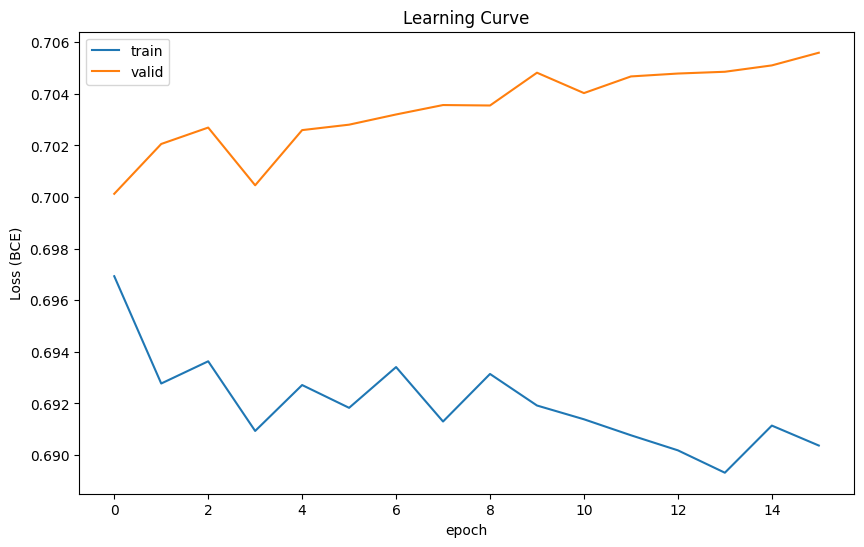

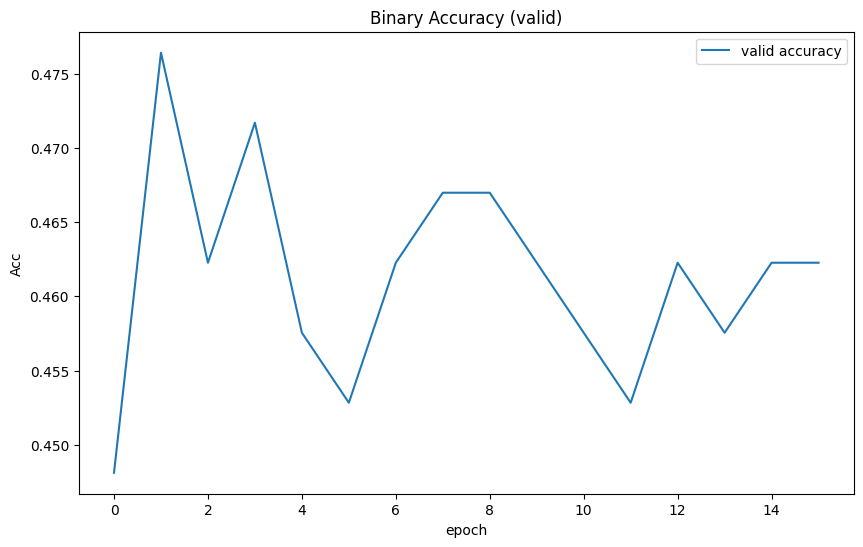

Training finished. Artifacts saved to C:\Users\jacin\DL_PROJECT\finance_transformer_lstm\TRANSFORMER\results


In [7]:
# === ARTEFAKTE SPEICHERN & PLOTTING ===
# Nach dem Training sichern wir alle Ergebnisse für die spätere Analyse.

# Trainingsverlauf als CSV speichern
pd.DataFrame(history).to_csv(RESULTS_DIR / "history.csv", index=False)

# Konfiguration speichern (wichtig für Reproduzierbarkeit)
# Wir speichern auch die verwendeten Feature-Spalten.
with open(RESULTS_DIR / "config.json", "w") as f:
    json.dump({"cfg": CFG, "feat_cols": feat_cols}, f, indent=2)

# Scaler speichern für spätere Verwendung (z.B. im Backtest Notebook für Testdaten)
with open(RESULTS_DIR / "scaler.pkl", "wb") as f:
    pickle.dump({"scaler": scaler, "feat_cols": feat_cols}, f)
    
# === PLOTTING ===
# Wir visualisieren den Trainingsverlauf.
hist_df = pd.DataFrame(history)

# 1. Learning Curve (Loss)
# Zeigt, ob das Modell lernt (Loss sinkt) und ob Overfitting vorliegt (Train sinkt, Val steigt).
plt.figure(figsize=(10, 6))
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="valid")
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("Loss (BCE)")
plt.legend()
plt.savefig(RESULTS_DIR / "loss.png")
plt.show()

# 2. Binary Accuracy
# Zeigt die Genauigkeit auf dem Validierungsset über die Zeit.
plt.figure(figsize=(10, 6))
plt.plot(hist_df["epoch"], hist_df["val_acc"], label="valid accuracy")
plt.title("Binary Accuracy (valid)")
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.legend()
plt.savefig(RESULTS_DIR / "valid_diracc.png")
plt.show()

print(f"Training finished. Artifacts saved to {RESULTS_DIR}")